# Progetto clustering Apartments Rent
### Parte DB-Scan
In questa sezione di codice utilizziamo la metodologia di clustering DB-Scan per effettuare analisi sul DataSet e trarne considerazioni[

### Setup
Inserisco nel blocco di codice sottostante tutti gli import e le installazioni necessarie al fine di effettuare le manipolazioni sui dati e all'esecuzione delle funzioni



In [ ]:
!pip install kneed
!pip install hdbscan


import pandas as pd
import seaborn as sns
import hdbscan
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.neighbors import NearestNeighbors
import numpy as np
from kneed import KneeLocator
from sklearn.manifold import TSNE

#monto il drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 16.1 MB/s eta 0:00:00
Mounted at /content/drive


### Lettura del DataSet

Eseguo la lettura del DataSet per poter avere accesso ai dati e poterli manipolare



In [ ]:
#Inizializzo il path del dataset
path = '/content/drive/MyDrive/DataSet/Rent/apartments_for_rent_classified_10K.csv'


#leggo il file
df = pd.read_csv(path, encoding="windows-1252",sep=";")

display(df)


,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668626895,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,Thumbnail,...,$790,Monthly,101,NaN,Washington,DC,38.9057,-76.9861,RentLingo,1577359415
1,5664597177,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,Thumbnail,...,$425,Monthly,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,RentLingo,1577017063
2,5668626833,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,Thumbnail,...,"$1,390",Monthly,107,NaN,Arlington,VA,38.8910,-77.0816,RentLingo,1577359410
3,5659918074,housing/rent/apartment,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,USD,No,Thumbnail,...,$925,Monthly,116,1717 12th Avenue,Seattle,WA,47.6160,-122.3275,RentLingo,1576667743
4,5668626759,housing/rent/apartment,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,USD,No,Thumbnail,...,$880,Monthly,125,NaN,Arlington,VA,38.8738,-77.1055,RentLingo,1577359401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5630240092,housing/rent/apartment,Five BR 5407 Abbott Place - Abbott,This unit is located at 5407 Abbott Place - Ab...,NaN,4.0,5.0,USD,No,Thumbnail,...,"$6,000",Monthly,6300,5407 Abbott Place Abbott,Edina,MN,44.9000,-93.3233,RentLingo,1575112975
9996,5668640983,housing/rent/apartment,Six BR 256 Las Entradas,"This unit is located at 256 Las Entradas, Mont...",NaN,8.0,6.0,USD,No,Thumbnail,...,"$25,000",Monthly,8716,256 Las Entradas,Montecito,CA,34.4331,-119.6331,RentLingo,1577360419
9997,5668643292,housing/rent/apartment,Six BR 9908 Bentcross Drive,"This unit is located at 9908 Bentcross Drive, ...",NaN,8.5,6.0,USD,No,Thumbnail,...,"$11,000",Monthly,11318,9908 Bentcross Dr,Potomac,MD,39.0287,-77.2409,RentLingo,1577360560
9998,5668662559,housing/rent/apartment,One BR in New York NY 10069,"Monthly Rent$4,605 -to $4,790AmenitiesThe Aldy...","Basketball,Cable or Satellite,Doorman,Hot Tub,...",NaN,1.0,USD,No,Thumbnail,...,"$4,790",Monthly,40000,NaN,New York,NY,40.7716,-73.9876,Listanza,1577362186


### DB-Scan (1)
Vado ad eseguire il DB-Scan su 6 parametri:"**bedrooms**","**price**","**square_feet**"

#### Selezione dei parametri
Seleziono i parametri ed eseguo l'elbow method in maniera tale da trovare il valore di eps

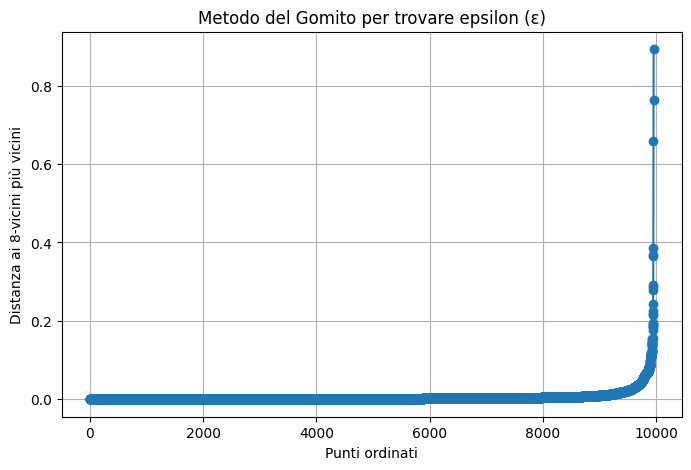

0.07361085752275533

In [ ]:
#Seleziono i parametri di riferimento
X = df[["price", "square_feet", "bedrooms", "bathrooms"]].dropna()
df_wk = df.loc[X.index].copy()

#creo X_scaled
X_scaled = MinMaxScaler().fit_transform(X)

# Scegliamo k = min_samples (regola empirica: 2-4 volte il numero di feature)
k = 8
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Ordiniamo le distanze in ordine decrescente
distances = np.sort(distances[:, k-1])

# Grafico per trovare il punto di gomito
plt.figure(figsize=(8, 5))
plt.plot(distances, marker="o", linestyle="-")
plt.xlabel("Punti ordinati")
plt.ylabel(f"Distanza ai {k}-vicini più vicini")
plt.title("Metodo del Gomito per trovare epsilon (ε)")
plt.grid()
plt.show()

# Trova il punto di gomito
knee_locator = KneeLocator(
    x=range(len(distances)),  # L'asse X deve essere la posizione dei punti
    y=distances,
    curve='convex',
    direction='increasing'  # Le distanze aumentano, quindi 'increasing'
)
elbow_point = knee_locator.elbow_y
display(elbow_point)

#### Eseguo il DB-Scan
Ho trovato l'elbow_point che indica il valore ottimale per il parametro eps

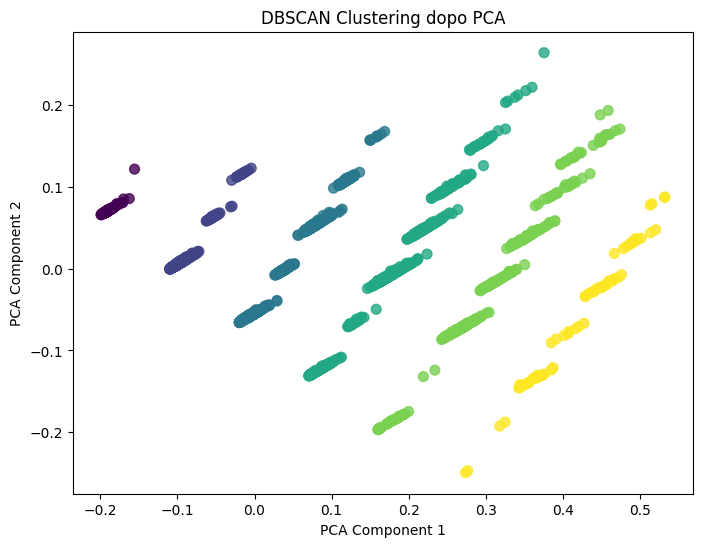

[0.83504955 0.96212838]
cluster
1    4594
2    3388
3    1273
4     393
0     184
5      73
Name: count, dtype: int64


In [ ]:

# Eseguo DBSCAN con eps calcolato
dbscan = DBSCAN(eps=elbow_point, min_samples=k)
labels = dbscan.fit_predict(X_scaled)

# Assicuriamoci che labels e df abbiano la stessa lunghezza
assert len(labels) == len(df_wk), f"Mismatch: labels ({len(labels)}) vs df ({len(df_wk)})"

# Aggiunta delle etichette di cluster
df_wk["cluster"] = labels

# Creiamo una maschera booleana per filtrare solo i punti non outlier
mask = df_wk["cluster"] != -1
df_filtered = df_wk[mask].copy() # Manteniamo solo i punti che non sono outlier
X_scaled_filtered = X_scaled[mask]  # Stessa operazione su X_scaled


# Rifacciamo PCA dopo la pulizia
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_filtered)

# Aggiorniamo il DataFrame con le componenti PCA
df_filtered["PCA1"] = X_pca[:, 0]
df_filtered["PCA2"] = X_pca[:, 1]

# Visualizzazione dei risultati senza outlier
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_filtered["PCA1"], df_filtered["PCA2"], c=df_filtered["cluster"], alpha=0.8, s= 50)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering dopo PCA")
plt.show()

#% varianza
print(pca.explained_variance_ratio_.cumsum())

#Stampa i cluster
print(df_filtered["cluster"].value_counts())


#### Traccio il grafico delle distanze
Una volta tracciato il grafico e trovato l'elbow point e settato il valore del k possiamo eseguire il DB-Scan

### DB-Scan (2)
DB-Scan effettuato sui parametri "latitude" e "longitude"

#### Inizio trovando i valori di eps e min_samples


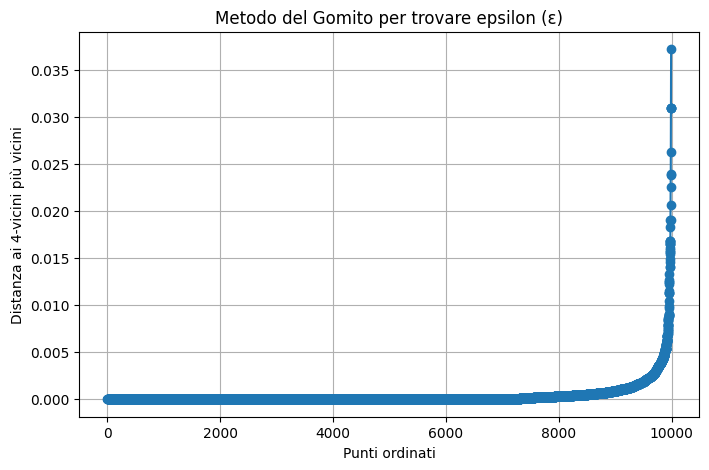

0.030929608302399148

In [ ]:
#Seleziono i parametri di riferimento
X = df[["longitude","latitude"]].dropna()

#scalo i valori di X
X_scaled = np.radians(X)

# Scegliamo k = min_samples (regola empirica: 2-4 volte il numero di feature)
k = 4
nbrs = NearestNeighbors(n_neighbors=k, metric="haversine").fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Ordiniamo le distanze in ordine decrescente
distances = np.sort(distances[:, k-1], axis=0)

# Grafico per trovare il punto di gomito
plt.figure(figsize=(8, 5))
plt.plot(distances, marker="o", linestyle="-")
plt.xlabel("Punti ordinati")
plt.ylabel(f"Distanza ai {k}-vicini più vicini")
plt.title("Metodo del Gomito per trovare epsilon (ε)")
plt.grid()
plt.show()

# Trova il punto di gomito
knee_locator = KneeLocator(
    x=range(len(distances)),
    y=distances,
    curve='convex',
    direction='increasing'
)
elbow_point = knee_locator.elbow_y
display(elbow_point)

#### Trovato il valore eseguo DB-Scan

61

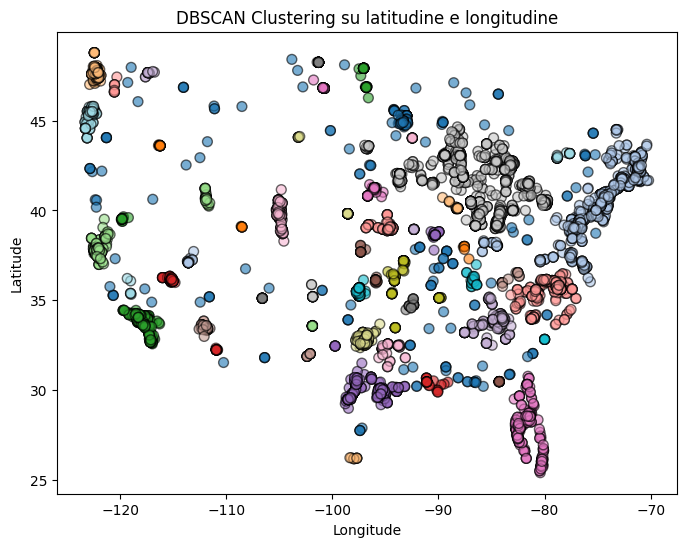

In [ ]:
# Selezionare solo latitudine e longitudine
df_geo = df[['latitude', 'longitude']].dropna()

# Convertire in radianti per DBSCAN con metrica Haversine
df_geo = df_geo[(df_geo["latitude"] > 24) & (df_geo["latitude"] < 50) & (df_geo["longitude"] > -130) & (df_geo["longitude"] < -60)]
X_geo_rad = np.radians(df_geo.values)

# Usare il metodo del gomito per trovare eps
k = 4
nbrs = NearestNeighbors(n_neighbors=k, metric="haversine").fit(X_geo_rad)
distances, indices = nbrs.kneighbors(X_geo_rad)
distances = np.sort(distances[:, k-1], axis=0)

# Applichiamo DBSCAN con eps calcolato
eps_optimal = distances[int(len(distances) * 0.90)]  # Prendiamo un valore vicino al 95° percentile

dbscan = DBSCAN(eps=0.0132, min_samples=6, metric="haversine")
labels = dbscan.fit_predict(X_geo_rad)


# Creiamo una palette con un numero di colori uguale ai cluster unici
unique_labels = np.unique(labels)
num_clusters = len(unique_labels)

# Generiamo colori distinti per ogni cluster
palette = sns.color_palette("tab20", num_clusters)
color_dict = {label: palette[i] for i, label in enumerate(unique_labels)}

# Assegniamo un colore unico a ogni punto
colors = [color_dict[label] for label in labels]

# Plot migliorato
plt.figure(figsize=(8, 6))
plt.scatter(df_geo["longitude"], df_geo["latitude"], c=colors, alpha=0.6, edgecolors='k', s=50)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clustering su latitudine e longitudine")

display(num_clusters)

### DB-Scan (3)
DB-Scan sui dati mq e costo \\
Plottati anche su latitudine e longitudine

In [ ]:
#Seleziono i parametri di riferimento
X = df

# Rimozione outlier con metodo IQR
Q1 = X["price"].quantile(0.25)
Q3 = X["price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

Q1_sqft = X["square_feet"].quantile(0.25)
Q3_sqft = X["square_feet"].quantile(0.75)
IQR_sqft = Q3_sqft - Q1_sqft
lower_bound_sqft = Q1_sqft - 1.5 * IQR_sqft
upper_bound_sqft = Q3_sqft + 1.5 * IQR_sqft

# Filtriamo il dataset
X_filtered = X[(X["price"] >= lower_bound) & (X["price"] <= upper_bound)]
X_filtered = X_filtered[(X_filtered["square_feet"] >= lower_bound_sqft) & (X_filtered["square_feet"] <= upper_bound_sqft)]

#scalo i valori di X
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_filtered[["price","square_feet"]].dropna())

# Scegliamo k = min_samples (regola empirica: 2-4 volte il numero di feature)
k = 4
nbrs = NearestNeighbors(n_neighbors=k,).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Ordiniamo le distanze in ordine decrescente
distances = np.sort(distances[:, k-1], axis=0)

# Grafico per trovare il punto di gomito
plt.figure(figsize=(8, 5))
plt.plot(distances, marker="o", linestyle="-")
plt.xlabel("Punti ordinati")
plt.ylabel(f"Distanza ai {k}-vicini più vicini")
plt.title("Metodo del Gomito per trovare epsilon (ε)")
plt.show()

# Trova il punto di gomito
knee_locator = KneeLocator(
    x=range(len(distances)),
    y=distances,
    curve='convex',
    direction='increasing'
)
elbow_point = knee_locator.elbow_y
display(elbow_point)

NameError: name 'df' is not defined

#### Stampo su scatter plot per prezzo e metri quadri

In [ ]:

#Eseguo DB_Scam
dbscan = DBSCAN(eps=0.005, min_samples=k,)
labels = dbscan.fit_predict(X_scaled)

# Plot migliorato
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 1], X_scaled[:, 0], c=labels, cmap="tab10", alpha=0.6, edgecolors='k', s=10)
plt.xlabel("square_feet")
plt.ylabel("prezzo")
plt.title("DBSCAN Clustering su latitudine e longitudine ")
plt.show()

# Creiamo un DataFrame con i dati originali e le etichette dei cluster
df_clusters = X_filtered.copy()
df_clusters["Cluster"] = labels

# Conta quante istanze ci sono per ogni cluster
cluster_counts = df_clusters["Cluster"].value_counts().sort_index()

# Stampa il numero di punti per ciascun cluster
print("Numero di istanze per cluster:")
print(cluster_counts)


#### Plotting su latitudine e longitudine

Text(0.5, 1.0, 'DBSCAN Clustering su latitudine e longitudine (Colori unici per cluster)')

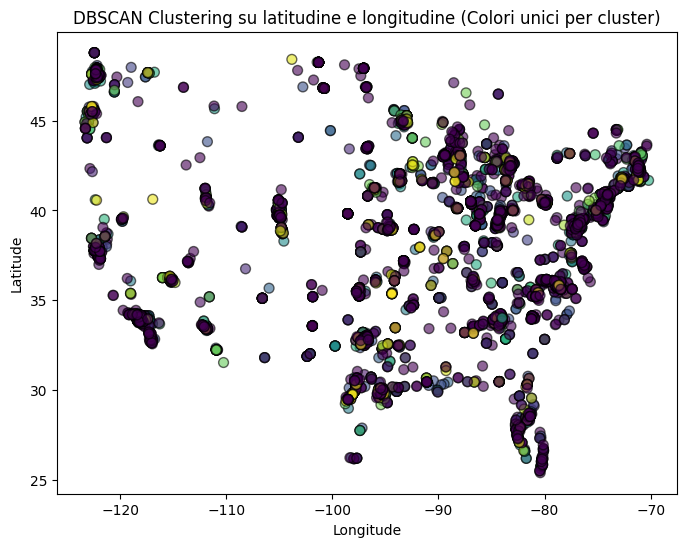

In [ ]:
df_geo = X_filtered

# Convertire in radianti per DBSCAN con metrica Haversine
df_geo = df_geo[(df_geo["latitude"] > 24) & (df_geo["latitude"] < 50) & (df_geo["longitude"] > -130) & (df_geo["longitude"] < -60)]

# Filtriamo anche labels per mantenere la corrispondenza con df_geo
filtered_labels = labels[(X_filtered["latitude"] > 24) & (X_filtered["latitude"] < 50) &
                         (X_filtered["longitude"] > -130) & (X_filtered["longitude"] < -60)]

# Verifica che df_geo e filtered_labels abbiano la stessa lun
plt.figure(figsize=(8, 6))
plt.scatter(df_geo["longitude"], df_geo["latitude"],alpha=0.6,c=filtered_labels,edgecolors='k', s=50)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clustering su latitudine e longitudine (Colori unici per cluster)")

\